In [1]:
!pip install tensorflow gradio --quiet

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ConvNeXtSmall
from tensorflow.keras.applications.convnext import preprocess_input

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import gradio as gr
from PIL import Image
import os

In [15]:
import zipfile # Import the zipfile module
from google.colab import files
uploaded = files.upload()

filename = next(iter(uploaded))  # get uploaded filename
extract_dir = '/content/e-waste'
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✅ Extracted to: {extract_dir}")

Saving E-Waste classification dataset.zip to E-Waste classification dataset (2).zip
✅ Extracted to: /content/e-waste


In [16]:
train_dir = ""
val_dir = ""

# Walk the extracted folder to find these directories
for root, dirs, files in os.walk(extract_dir):
    if 'train' in dirs:
        train_dir = os.path.join(root, 'train')
    if 'val' in dirs or 'validate' in dirs:
        val_dir = os.path.join(root, 'val') if 'val' in dirs else os.path.join(root, 'validate')

print(f"📂 Training directory found at: {train_dir}")
print(f"📂 Validation directory found at: {val_dir}")


📂 Training directory found at: /content/e-waste/modified-dataset/train
📂 Validation directory found at: /content/e-waste/modified-dataset/val


In [17]:
img_height, img_width = 128, 128
batch_size = 32

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

num_classes = len(train_generator.class_indices)
class_labels = list(train_generator.class_indices.keys())
print(f"🔍 Classes: {class_labels}")

Found 2400 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
🔍 Classes: ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


In [18]:
base_model = ConvNeXtSmall(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)
base_model.trainable = False  # freeze for fast training

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

In [19]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [20]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=5,
    validation_steps=2,
    epochs=3
)

Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35s/step - accuracy: 0.1395 - loss: 2.6514 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 274s 54s/step - accuracy: 0.1444 - loss: 2.6424 - val_accuracy: 0.5000 - val_loss: 1.6339
Epoch 2/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 260s 56s/step - accuracy: 0.3019 - loss: 2.1667 - val_accuracy: 0.6875 - val_loss: 1.2960
Epoch 3/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 263s 57s/step - accuracy: 0.4188 - loss: 1.6492 - val_accuracy: 0.7656 - val_loss: 1.0192


10/10 ━━━━━━━━━━━━━━━━━━━━ 331s 32s/step

Classification Report:
                 precision    recall  f1-score   support

        Battery       0.00      0.00      0.00        30
       Keyboard       0.09      0.13      0.11        30
      Microwave       0.06      0.07      0.06        30
         Mobile       0.00      0.00      0.00        30
          Mouse       0.04      0.03      0.04        30
            PCB       0.13      0.17      0.14        30
         Player       0.11      0.13      0.12        30
        Printer       0.06      0.07      0.06        30
     Television       0.08      0.07      0.07        30
Washing Machine       0.14      0.13      0.14        30

       accuracy                           0.08       300
      macro avg       0.07      0.08      0.07       300
   weighted avg       0.07      0.08      0.07       300



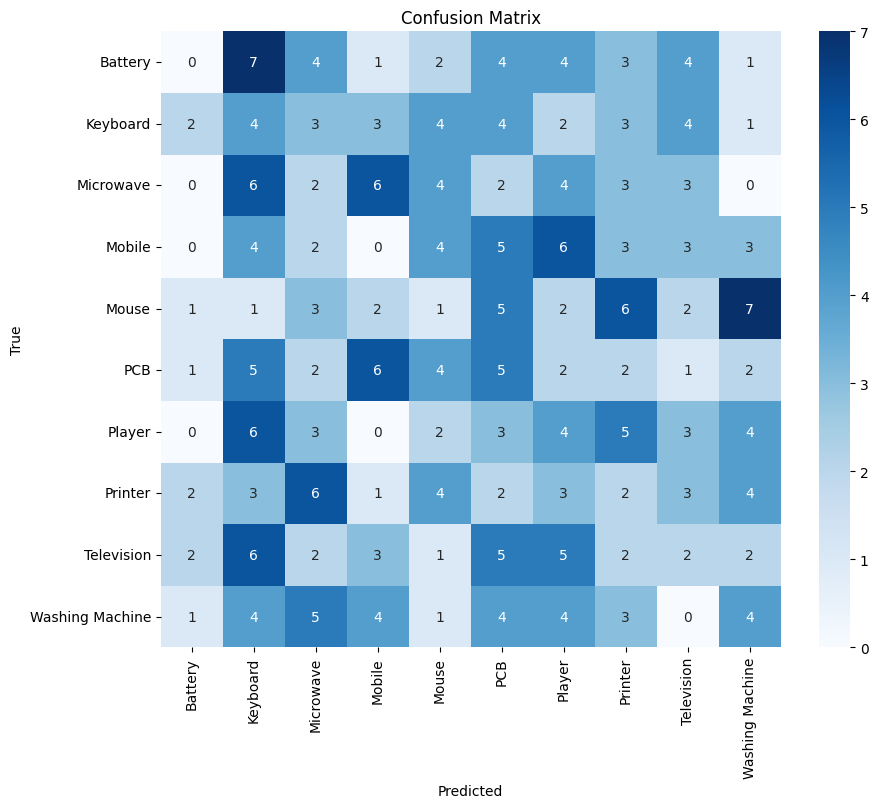

In [21]:
val_preds = model.predict(val_generator, verbose=1)
val_pred_classes = np.argmax(val_preds, axis=1)
true_classes = val_generator.classes

print("\nClassification Report:")
print(classification_report(true_classes, val_pred_classes, target_names=class_labels))

cm = confusion_matrix(true_classes, val_pred_classes)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [22]:
def classify_image(img):
    img = img.resize((img_width, img_height))
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    preds = model.predict(img_array)
    class_idx = np.argmax(preds, axis=1)[0]
    return class_labels[class_idx]

interface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type='pil'),
    outputs=gr.Label()
)

interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://243eae37256d94cdb0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# Inspect the extracted directory structure
!ls -R {extract_dir}